In [1]:
import base64
import collections
import copy
import cProfile
import datetime
import itertools
import json
import math
import os
import operator
import pickle
import random
import re
import shutil
import sys
import time

import bokeh
import cv2
import Image
import keras
from keras import *
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import prophet
import pyflux
import pylab
import scipy
from scipy import signal
import seaborn as sns
import skimage
import sklearn
from sklearn import *
import statsmodels as sm
import tensorflow as tf
import tqdm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
mpl.rcParams['figure.figsize'] = 20, 12
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

linewidth = 1.0
dotsize = 15

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/lo

In [2]:
mpl.rcParams['figure.figsize'] = 6, 6

In [3]:
d = pd.read_json('/media/ntfs/data/iceberg_classification/input/train.json').head(10)
print len(d)

10


In [4]:
i = np.asarray(d.iloc[0, 0]).reshape((75, 75))
i

array([[-27.878361, -27.15416 , -28.668615, ..., -25.573483, -26.488674,
        -30.507013],
       [-28.66853 , -27.878401, -27.508776, ..., -26.488632, -28.671562,
        -31.594166],
       [-28.66853 , -27.15416 , -25.865042, ..., -27.157106, -27.881393,
        -32.837124],
       ..., 
       [-29.092905, -28.669163, -30.504612, ..., -30.011005, -25.868538,
        -26.489265],
       [-31.591682, -27.878992, -28.669205, ..., -27.512272, -26.817074,
        -27.512358],
       [-29.092905, -26.814081, -27.154791, ..., -26.817032, -27.881983,
        -28.268127]])

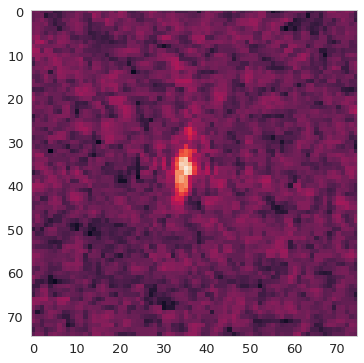

In [5]:
_ = plt.imshow(i)
plt.grid(False)

# Flip

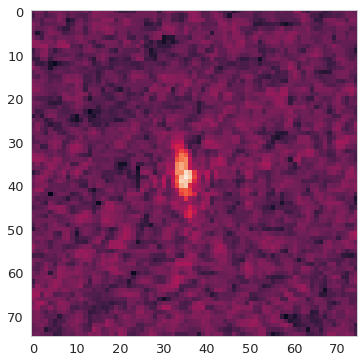

In [6]:
_ = plt.imshow(cv2.flip(i, 0))
plt.grid(False)

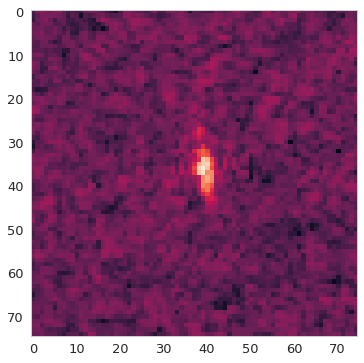

In [7]:
_ = plt.imshow(cv2.flip(i, 1))
plt.grid(False)

# Rotate 90

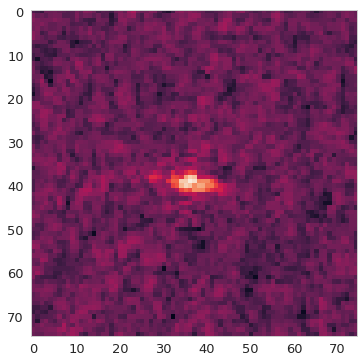

In [8]:
_ = plt.imshow(np.rot90(i, 1))
plt.grid(False)

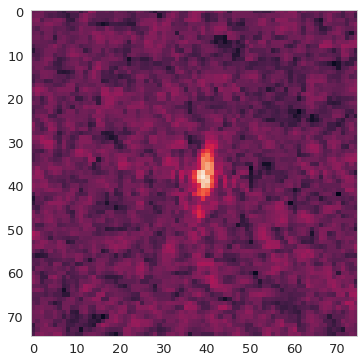

In [9]:
_ = plt.imshow(np.rot90(i, 2))
plt.grid(False)

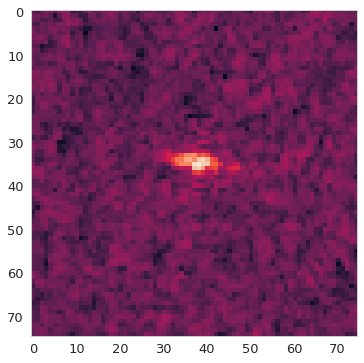

In [10]:
_ = plt.imshow(np.rot90(i, 3))
plt.grid(False)

# Add Noise

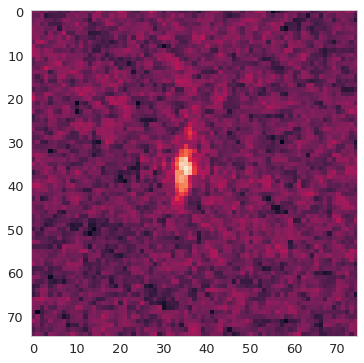

In [11]:
_ = plt.imshow(i + 0.05 * i * np.random.randn(75*75).reshape((75, 75)))
plt.grid(False)

# Keras PreProc Transformations

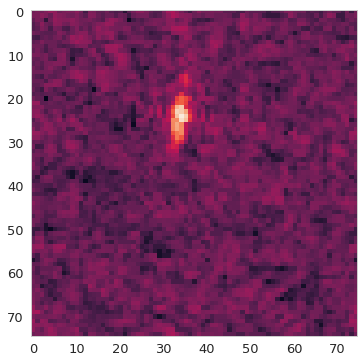

In [12]:
_ = plt.imshow(keras.preprocessing.image.random_shift(i.reshape((75, 75, 1)),
                                                      wrg=0.2,
                                                      hrg=0.2,
                                                      row_axis=0,
                                                      col_axis=1,
                                                      channel_axis=2,
                                                      fill_mode='wrap').reshape((75, 75)))
plt.grid(False)

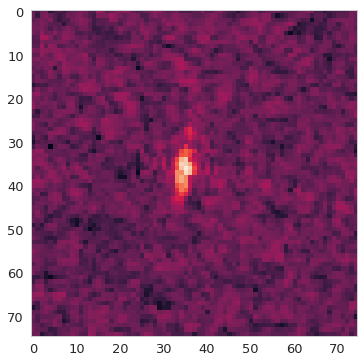

In [13]:
_ = plt.imshow(keras.preprocessing.image.random_rotation(i.reshape((75, 75, 1)),
                                                         rg=90,
                                                         row_axis=0,
                                                         col_axis=1,
                                                         channel_axis=2,
                                                         fill_mode='wrap').reshape((75, 75)))
plt.grid(False)

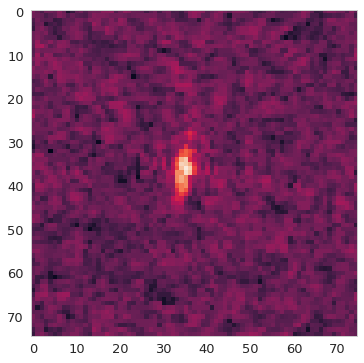

In [14]:
_ = plt.imshow(keras.preprocessing.image.random_zoom(i.reshape((75, 75, 1)),
                                                         zoom_range=(0.9, 1.1),
                                                         row_axis=0,
                                                         col_axis=1,
                                                         channel_axis=2,
                                                         fill_mode='wrap').reshape((75, 75)))
plt.grid(False)

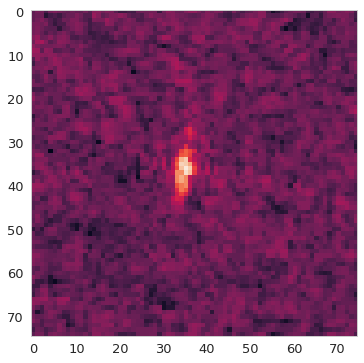

In [15]:
_ = plt.imshow(keras.preprocessing.image.random_shear(i.reshape((75, 75, 1)),
                                                         intensity=0.2,
                                                         row_axis=0,
                                                         col_axis=1,
                                                         channel_axis=2,
                                                         fill_mode='wrap').reshape((75, 75)))
plt.grid(False)

# Smoothing, Derivatives and Gradient Magnitude

In [16]:
xder11 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
xder12 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
yder11 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
yder12 = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

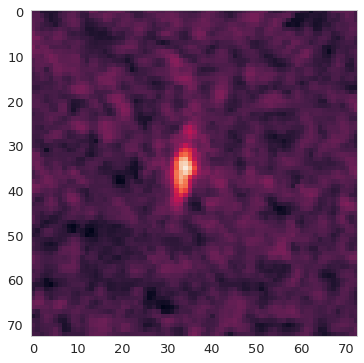

In [17]:
_ = plt.imshow(scipy.signal.convolve2d(i, smooth, mode='valid'))
plt.grid(False)

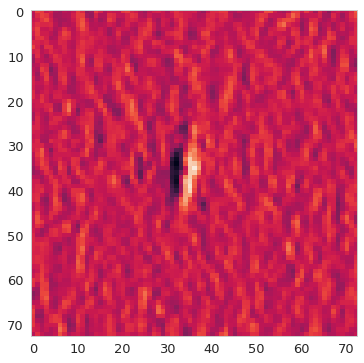

In [18]:
_ = plt.imshow(scipy.signal.convolve2d(i, xder11, mode='valid'))
plt.grid(False)

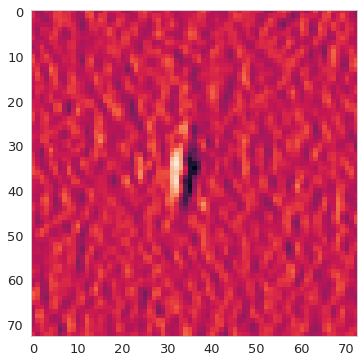

In [19]:
_ = plt.imshow(scipy.signal.convolve2d(i, xder12, mode='valid'))
plt.grid(False)

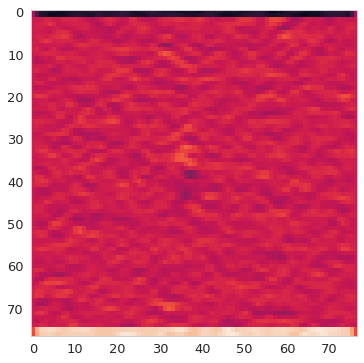

In [20]:
_ = plt.imshow(scipy.signal.convolve2d(i, yder11))
plt.grid(False)

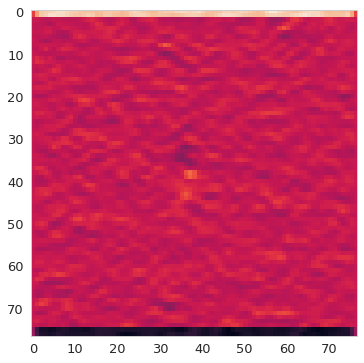

In [21]:
_ = plt.imshow(scipy.signal.convolve2d(i, yder12))
plt.grid(False)

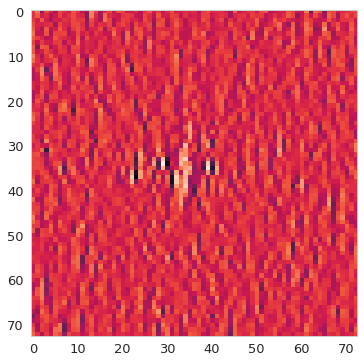

In [22]:
_ = plt.imshow(scipy.signal.convolve2d(i, xder2, mode='valid'))
plt.grid(False)

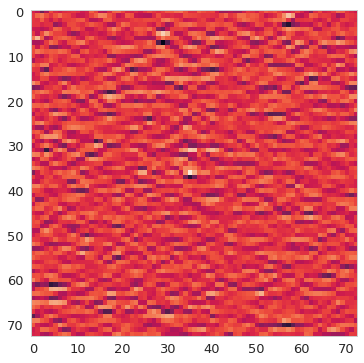

In [23]:
_ = plt.imshow(scipy.signal.convolve2d(i, yder2, mode='valid'))
plt.grid(False)

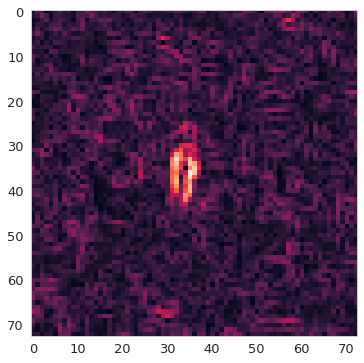

In [24]:
arx = scipy.signal.convolve2d(i, xder11, mode='valid')
ary = scipy.signal.convolve2d(i, yder11, mode='valid')
_ = plt.imshow(scipy.hypot(arx, ary))
plt.grid(False)

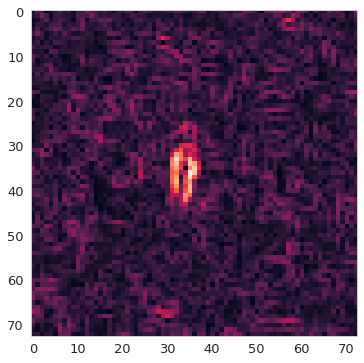

In [25]:
arx = scipy.signal.convolve2d(i, xder12, mode='valid')
ary = scipy.signal.convolve2d(i, yder12, mode='valid')
_ = plt.imshow(scipy.hypot(arx, ary))
plt.grid(False)

# Keras ImageDataGenerator

In [26]:
x = np.zeros((1, 75, 75, 3))
x[0, :, :, 0] = np.asarray(d.iloc[0, 0]).reshape((75, 75))
x[0, :, :, 1] = np.asarray(d.iloc[0, 1]).reshape((75, 75))
x[0, :, :, 2] = np.zeros((75, 75))
y = [0]

gen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=45.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        channel_shift_range=0.1,
        fill_mode='wrap',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True
        )
flow = gen.flow(x, y, batch_size=1)

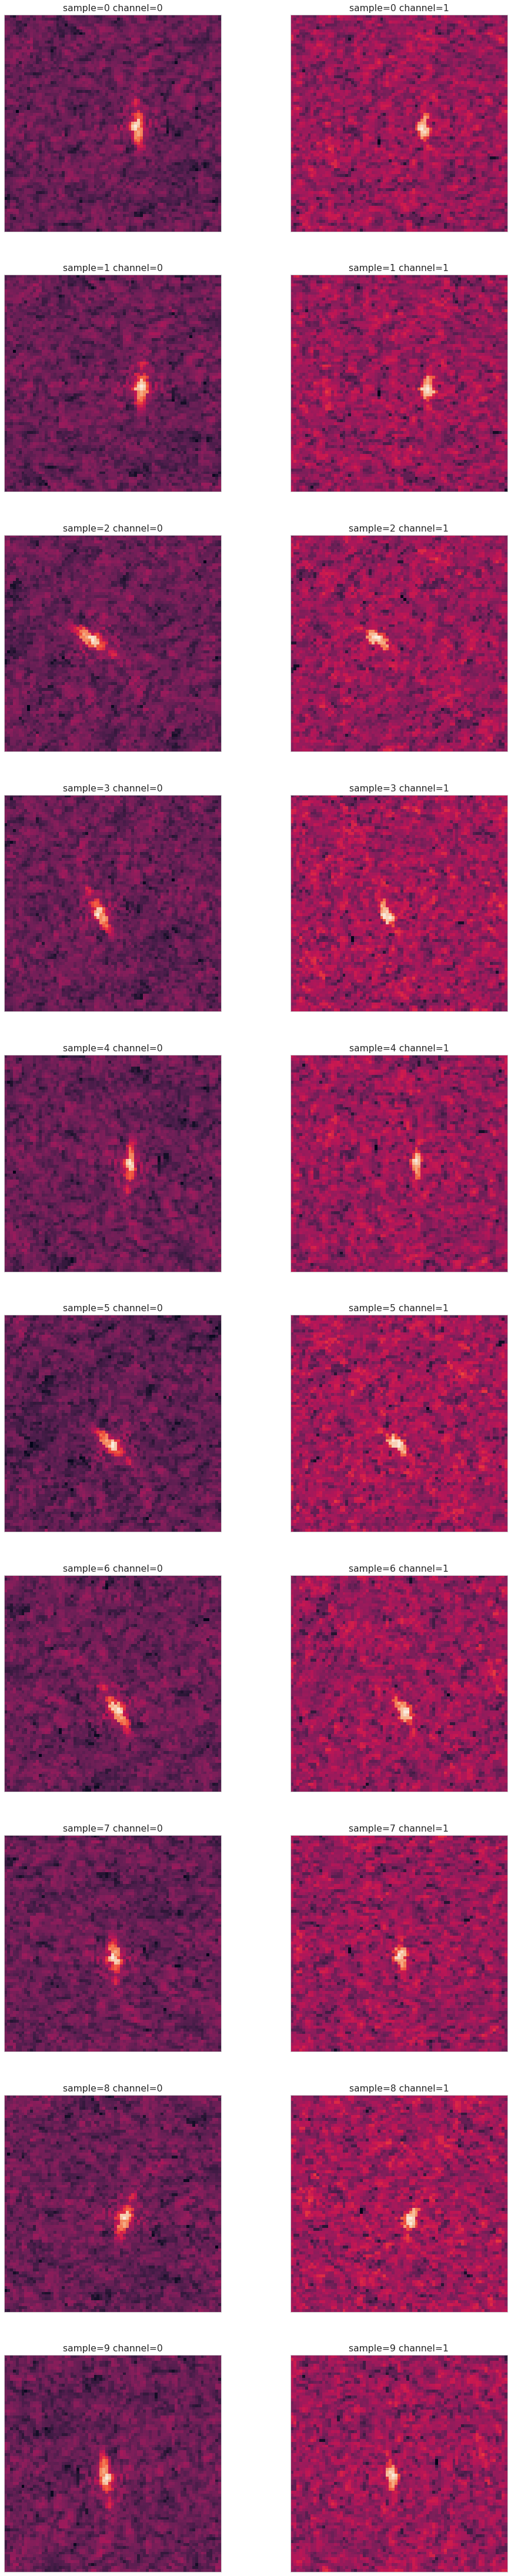

In [27]:
n_samples = 10
img_plot_size = 8

fig, ax = plt.subplots(n_samples, 2, figsize=(2*img_plot_size, img_plot_size*n_samples))
ax = ax.ravel()

k = 0
for f in flow:
    for j in range(2):
        ax[k*2 + j].imshow(f[0][0, :, :, j])
        ax[k*2 + j].grid(False)
        ax[k*2 + j].xaxis.set_ticks([])
        ax[k*2 + j].yaxis.set_ticks([])
        ax[k*2 + j].set_title('sample={0} channel={1}'.format(k, j))
    k += 1
    if k == n_samples:
        break